# Proton data in dilepton events

### Install packages

In [1]:
#!python3 -m pip install --user uproot4 awkward1 mplhep

In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep

### N-tuple processing

The data is first processed from a ROOT n-tuple. Below is an n-tuple from an MC sample.  
Look for the _ProtCand_ data defining the proton objects.

In [3]:
import uproot4
import awkward1 as ak

root = uproot4.open( "/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/MC-2017-v1/output_exclusive_new.root" )
tree = root["ggll_miniaod/ntp1"]

keys = ["Run", "LumiSection", "BX", "EventNum", "CrossingAngle","nHLT", "HLT_Accept", "HLT_Prescl", "HLT_Name",
        "nMuonCand", "MuonCand_pt", "MuonCand_eta", "MuonCand_phi", "MuonCand_e", "MuonCand_charge", "MuonCand_vtxz", "MuonCand_istight",
        "nPrimVertexCand", "PrimVertexCand_z", "PrimVertexCand_chi2", "PrimVertexCand_ndof", "PrimVertexCand_tracks",
        "Weight", "PUWeightTrue"]
keys.append( "nPfCand" )
keys.extend( tree.keys( filter_name="PfCand*" ) ) 
keys.append( "nRecoProtCand" )
keys.extend( tree.keys( filter_name="ProtCand*" ) )

arrays = tree.arrays( keys, library="ak", how="zip", entry_stop=10000 )
ak.to_list( arrays[:10] )

[{'Run': 1,
  'LumiSection': 1,
  'BX': 4294967295,
  'EventNum': 11,
  'CrossingAngle': -999.0,
  'nHLT': 3,
  'HLT_Name': ['HLT_DoubleMu43NoFiltersNoVtx_*',
   'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8_*',
   'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8_*'],
  'nMuonCand': 2,
  'nPrimVertexCand': 18,
  'Weight': 1.1115721770704978,
  'PUWeightTrue': 0.0,
  'nPfCand': 8,
  'nRecoProtCand': 0,
  'HLT': [{'Accept': 1, 'Prescl': 1},
   {'Accept': 1, 'Prescl': 1},
   {'Accept': 1, 'Prescl': 1}],
  'MuonCand': [{'pt': 64.26155090332031,
    'eta': -0.5968616604804993,
    'phi': -1.6632956266403198,
    'e': 76.05188502900157,
    'charge': 1,
    'vtxz': 5.145226001739502,
    'istight': 1},
   {'pt': 61.580448150634766,
    'eta': 1.0376110076904297,
    'phi': 1.481685996055603,
    'e': 97.81340011244389,
    'charge': -1,
    'vtxz': 5.143592357635498,
    'istight': 1}],
  'PrimVertexCand': [{'z': 5.1456708908081055,
    'chi2': 6.601336479187012,
    'ndof': 5,
    'tracks': 0},
  

The n-tuples are processed and the follwing event selection is applied:  

* Events are selected with unprescaled dimuon HLT triggers
* The two leading muons are required with transverse momentum larger than 50 GeV, to be of opposite charge and associated to the primary vertex in the longitudinal direction

The acoplanarity is defined as $1 - \lvert\Delta\phi(\mu\mu)\rvert / \pi$, where $\Delta\phi(\mu\mu)$ is the azimuthal angle difference between the two leading muons.

The number of extra tracks is calculated as those originating from the primary vertex which are separated in the azimuthal angle and pseudorapidity space from the two leading muons.

The data is then _flattened_ over the proton objects, as will be seen below.

### Proton reconstruction flavours

We will look at two ways to reconstruct protons in PPS: _single-RP_ and _multi-RP_

The flag below controls which proton reconstruction is used.

In the multi-RP reconstruction, both "near" and "far" tracking detector stations in one spectrometer arm are used. 

In the single-RP reconstruction, the proton kinematics is only partially reconstructed from a single detector station. In this case we will use the "far" station. In the 2017 detector configuration, this corresponds to the stations using pixel detectors.

In [4]:
fileName_signal = "data/output-MC2017-Elastic-PreSel.h5"
#fileName_data = "data/output-UL2017B-PreSel.h5"
fileName_data = "data/output-UL2017C1-PreSel.h5"

proton_selection = "SingleRP"
#proton_selection = "MultiRP"

# Signal

## Access the data

In [5]:
df_signal = None
event_counts_signal = None
selections_str_signal = None

with h5py.File( fileName_signal, 'r' ) as f:
    print ( list(f.keys()) )
    dset = f['protons']
    print ( dset.shape )
    print ( dset[:,:] )
    dset_columns = f['columns']
    print ( dset_columns.shape )
    columns = list( dset_columns )
    print ( columns )
    columns_str = [ item.decode("utf-8") for item in columns ]
    print ( columns_str )
    
    dset_counts = f['event_counts']
    event_counts_signal = list( dset_counts )
    print ( event_counts_signal )
    
    dset_selections = f['selections']
    selections_ = list( dset_selections )
    print ( selections_ )
    selections_str_signal = [ item.decode("utf-8") for item in selections_ ]
    print ( selections_str_signal )
    
    df_signal = pd.DataFrame( dset, columns=columns_str )
    
    df_signal = df_signal[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
                            'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
                            'Xi', 'T', 'ThX', 'ThY',
                            'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )
    

['columns', 'event_counts', 'protons', 'selections']
(212317, 38)
[[1.00000000e+00 1.00000000e+00 4.29496730e+09 ... 9.13764843e-04
  2.35298625e-02 4.41197067e-03]
 [1.00000000e+00 1.00000000e+00 4.29496730e+09 ... 8.79983866e-04
  4.58796041e-03 8.15103097e-02]
 [1.00000000e+00 1.00000000e+00 4.29496730e+09 ... 8.79983866e-04
  4.58796041e-03 8.15103097e-02]
 ...
 [1.00000000e+00 7.56000000e+02 4.29496730e+09 ... 1.85212595e-04
  3.62914948e-02 3.05966531e-03]
 [1.00000000e+00 7.56000000e+02 4.29496730e+09 ... 1.85212595e-04
  3.62914948e-02 3.05966531e-03]
 [1.00000000e+00 7.56000000e+02 4.29496730e+09 ... 1.50995244e-04
  2.04409396e-02 4.87857127e-03]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP', b'Muon0

In [6]:
df_signal[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,T,ThX,ThY,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus
0,1,1,5,-999.0,0,-999,23,-1,2.143066,2.999878e-01,...,-4.193081,0.000000,-3.187507e-04,63.039753,62.647861,132.454602,34,0.000914,0.023530,0.004412
1,1,1,3,-999.0,0,-999,103,-1,7.713867,1.057861e+00,...,-0.031876,0.000000,-2.301511e-05,115.289131,114.552933,251.395353,16,0.000880,0.004588,0.081510
2,1,1,3,-999.0,0,-999,123,-1,7.870300,1.150024e+00,...,-0.031457,0.000000,-2.232364e-05,115.289131,114.552933,251.395353,16,0.000880,0.004588,0.081510
3,1,1,3,-999.0,1,1,103,123,7.713867,1.057861e+00,...,-0.391821,0.000099,6.278088e-06,115.289131,114.552933,251.395353,16,0.000880,0.004588,0.081510
4,1,1,12,-999.0,0,-999,3,-1,4.123291,4.024048e-01,...,-0.079966,0.000000,-4.399618e-05,55.317619,52.814793,126.690612,4,0.001160,0.055618,0.001708
5,1,1,12,-999.0,0,-999,23,-1,3.964905,3.500061e-01,...,-0.049783,0.000000,-3.449587e-05,55.317619,52.814793,126.690612,4,0.001160,0.055618,0.001708
6,1,1,12,-999.0,1,0,3,23,4.123291,4.024048e-01,...,-0.308889,-0.000085,2.199164e-05,55.317619,52.814793,126.690612,4,0.001160,0.055618,0.001708
7,1,1,15,-999.0,0,-999,103,-1,4.597168,1.631836e+00,...,-0.212707,0.000000,-7.275571e-05,89.590111,88.274399,195.115391,10,0.000011,0.003281,0.068651
8,1,1,15,-999.0,0,-999,123,-1,4.530273,1.750000e+00,...,-0.197739,0.000000,-7.009306e-05,89.590111,88.274399,195.115391,10,0.000011,0.003281,0.068651
9,1,1,15,-999.0,1,1,103,123,4.597168,1.631836e+00,...,-0.004889,0.000003,4.680393e-07,89.590111,88.274399,195.115391,10,0.000011,0.003281,0.068651


In [7]:
df_counts_signal = pd.Series( event_counts_signal, index=selections_str_signal );
df_counts_signal

All        178402
Muon       166756
Vertex     149608
Protons     90874
dtype: int64

Text(0.5, 0, 'Number of $\\it{extra}$ tracks')

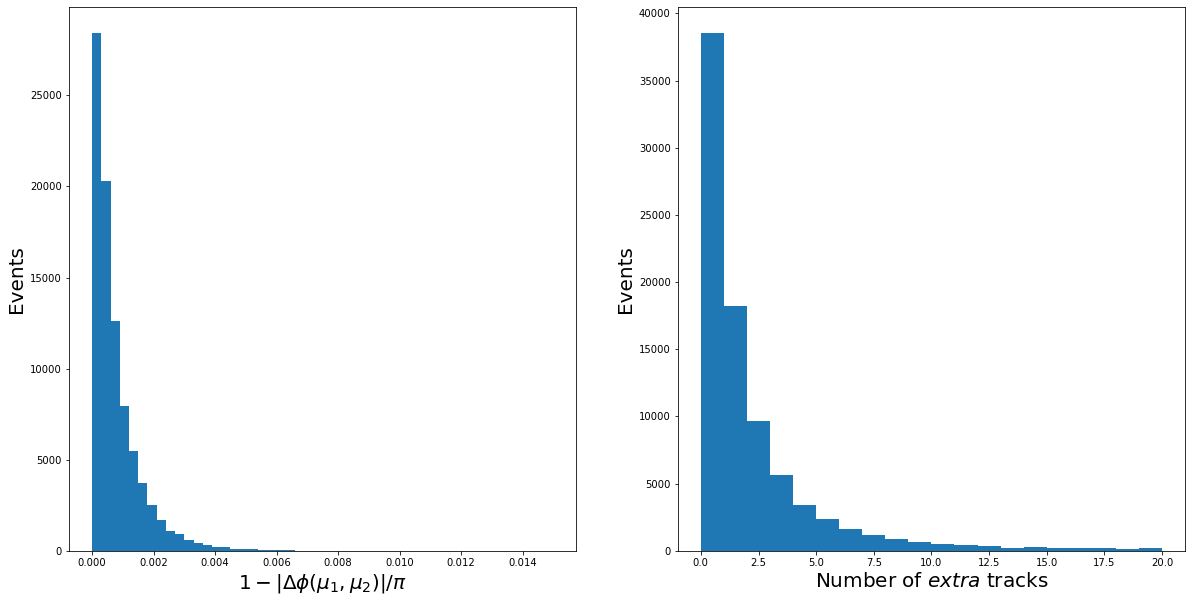

In [8]:
df_signal_events = df_signal.set_index( ["Run", "LumiSection", "EventNum"] ).drop( columns=['Xi', 'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2'] )
df_signal_events = df_signal_events[ ~df_signal_events.index.duplicated(keep='first') ]

msk_invmass = ( df_signal_events["InvMass"] >= 110. )
df_signal_events = df_signal_events[msk_invmass]

fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].hist( df_signal_events["Acopl"], bins=50, range=(0.,0.015) )
axes[0].set_ylabel( "Events", fontsize=20 )
axes[0].set_xlabel( r"$1 - \vert\Delta\phi(\mu_1,\mu_2)\vert/\pi$", fontsize=20 )
axes[1].hist( df_signal_events["ExtraPfCands"], bins=20, range=(0,20) )
axes[1].set_ylabel( "Events", fontsize=20 )
axes[1].set_xlabel( r"Number of $\it{extra}$ tracks", fontsize=20 )

Text(0, 0.5, 'Y (mm)')

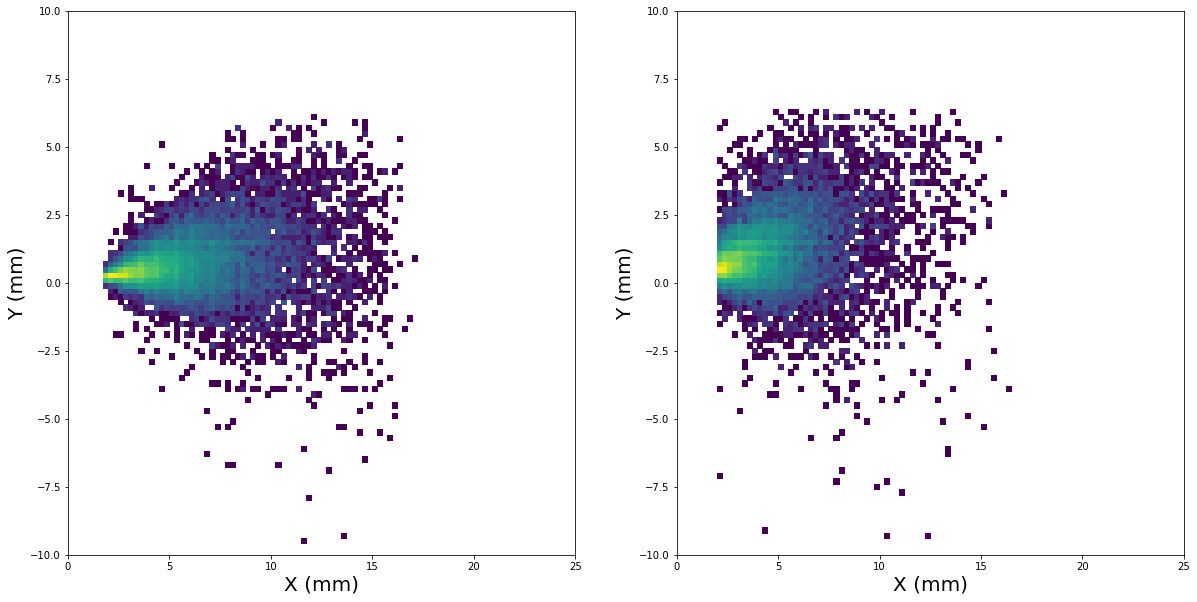

In [9]:
from matplotlib.colors import LogNorm

msk_excl = ( df_signal["InvMass"] >= 110. ) & ( df_signal["Acopl"] <= 0.009 ) & ( df_signal["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 1 )
    
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].hist2d( df_signal[ "TrackX1" ][ msk_protons_1 ], df_signal[ "TrackY1" ][ msk_protons_1 ], bins=(100,100), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[0].set_xlabel( "X (mm)", fontsize=20 )
axes[0].set_ylabel( "Y (mm)", fontsize=20 )
axes[1].hist2d( df_signal[ "TrackX1" ][ msk_protons_2 ], df_signal[ "TrackY1" ][ msk_protons_2 ], bins=(100,100), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[1].set_xlabel( "X (mm)", fontsize=20 )
axes[1].set_ylabel( "Y (mm)", fontsize=20 )

Proton selection: SingleRP
Number of protons: 34543, 24034


Text(0, 0.5, '$\\xi_{\\mu\\mu}$')

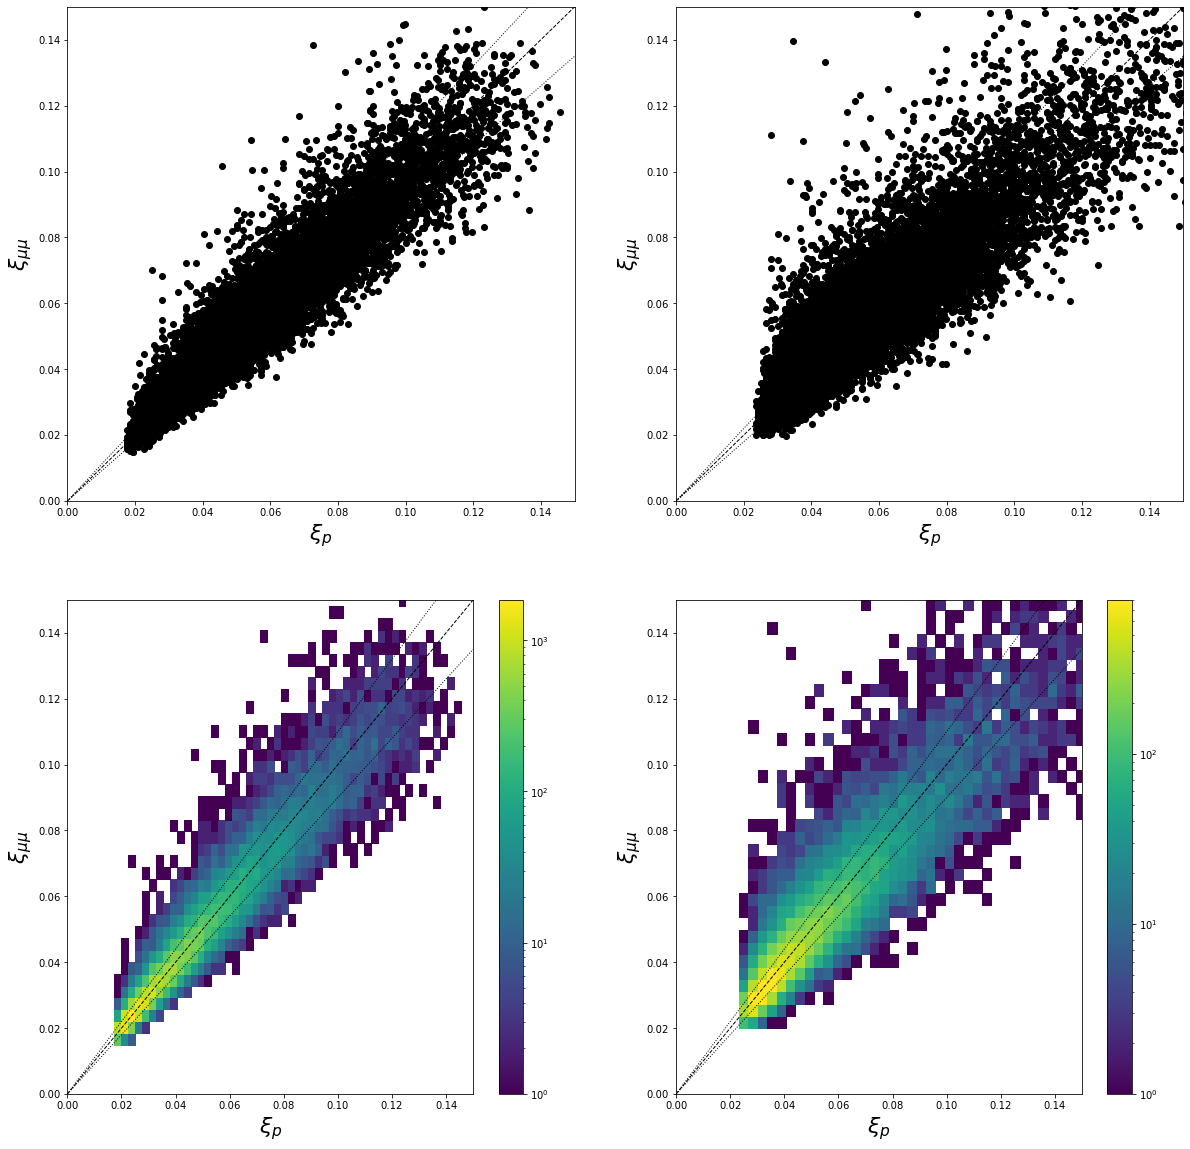

In [10]:
msk_excl = ( df_signal["InvMass"] >= 110. ) & ( df_signal["Acopl"] <= 0.009 ) & ( df_signal["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 1 )

print ( "Proton selection: {}".format( proton_selection ) )
print ( "Number of protons: {}, {}".format( len( df_signal[ "Xi" ][ msk_protons_1 ] ), len( df_signal[ "Xi" ][ msk_protons_2 ] ) ) )

fig, axes = plt.subplots( 2, 2, figsize=(20,20) )
axes[0,0].plot( df_signal[ "Xi" ][ msk_protons_1 ], df_signal[ "XiMuMuPlus" ][ msk_protons_1 ], 'ko' )
axes[0,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,0].set_xlim(0.,0.15)
axes[0,0].set_ylim(0.,0.15)
axes[0,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
#axes[0,0].set_xlabel( r"$\xi_p$", fontsize=22, ha='right', x=1.0 )
#axes[0,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22, ha='right', y=1.0 )
axes[0,1].plot( df_signal[ "Xi" ][ msk_protons_2 ], df_signal[ "XiMuMuMinus" ][ msk_protons_2 ], 'ko' )
axes[0,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,1].set_xlim(0.,0.15)
axes[0,1].set_ylim(0.,0.15)
axes[0,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,0].hist2d( df_signal[ "Xi" ][ msk_protons_1 ], df_signal[ "XiMuMuPlus" ][ msk_protons_1 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,0])
axes[1,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,0].set_xlim(0.,0.15)
axes[1,0].set_ylim(0.,0.15)
axes[1,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,1].hist2d( df_signal[ "Xi" ][ msk_protons_2 ], df_signal[ "XiMuMuMinus" ][ msk_protons_2 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,1])
axes[1,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,1].set_xlim(0.,0.15)
axes[1,1].set_ylim(0.,0.15)
axes[1,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )

# Data

In [11]:
df_data_list = []
df_counts_data_list = []

with h5py.File( fileName_data, 'r') as f:    
    print ( list(f.keys()) )
    dset = f['protons']
    print ( dset.shape )
    print ( dset[:,:] )
    
    dset_columns = f['columns']
    print ( dset_columns.shape )
    columns = list( dset_columns )
    print ( columns )
    columns_str = [ item.decode("utf-8") for item in columns ]
    print ( columns_str )

    dset_selections = f['selections']
    selections_ = [ item.decode("utf-8") for item in dset_selections ]
    print ( selections_ )  
        
    dset_counts = f['event_counts']
    df_counts_data_list.append( pd.Series( dset_counts, index=selections_ ) )
    print ( df_counts_data_list[-1] )
    
    chunk_size = 1000000
    entries = dset.shape[0]
    start_ = list( range( 0, entries, chunk_size ) )
    stop_ = start_[1:]
    stop_.append( entries )
    print ( start_ )
    print ( stop_ )
    for idx in range( len( start_ ) ):
        print ( start_[idx], stop_[idx] )
        #print ( dset[ start_[idx] : stop_[idx] ] )
        df_ = pd.DataFrame( dset[ start_[idx] : stop_[idx] ], columns=columns_str )
        df_ = df_[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
                    'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
                    'Xi', 'T', 'ThX', 'ThY',
                    'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )
        df_data_list.append( df_ )
        print ( df_data_list[-1].head() )
        print ( len( df_data_list[-1] ) )

df_data = pd.concat( df_data_list )
df_data[:20]

['columns', 'event_counts', 'protons', 'selections']
(293526, 38)
[[3.00633000e+05 2.42000000e+02 2.37000000e+03 ... 9.97373280e-01
  1.55540936e-02 9.52024583e-03]
 [3.00633000e+05 2.42000000e+02 2.37000000e+03 ... 9.97373280e-01
  1.55540936e-02 9.52024583e-03]
 [3.00633000e+05 2.42000000e+02 3.25500000e+03 ... 3.76291311e-03
  7.38923917e-03 9.64585294e-02]
 ...
 [3.00560000e+05 4.10000000e+01 2.20200000e+03 ... 8.18128660e-03
  6.17002376e-03 1.92005237e-02]
 [3.00560000e+05 4.10000000e+01 2.20200000e+03 ... 8.18128660e-03
  6.17002376e-03 1.92005237e-02]
 [3.00560000e+05 4.10000000e+01 2.20200000e+03 ... 8.18128660e-03
  6.17002376e-03 1.92005237e-02]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP', b'Muon0

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,T,ThX,ThY,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus
0,300633,242,371717750,140.0,0,-999,3,-1,17.977539,-20.718750,...,-2.929726,0.000000,2.846836e-04,94.443443,63.750408,0.657015,29,0.997373,0.015554,0.009520
1,300633,242,371717750,140.0,0,-999,123,-1,3.656494,-0.416718,...,-0.029679,0.000000,2.601933e-05,94.443443,63.750408,0.657015,29,0.997373,0.015554,0.009520
2,300633,242,371473466,140.0,0,-999,23,-1,4.911011,0.529053,...,-0.061912,0.000000,-3.854835e-05,144.700897,142.025604,347.052719,15,0.003763,0.007389,0.096459
3,300633,242,371473466,140.0,0,-999,23,-1,5.698364,0.022293,...,-0.002993,0.000000,-1.273629e-06,144.700897,142.025604,347.052719,15,0.003763,0.007389,0.096459
4,300633,242,371473466,140.0,0,-999,103,-1,4.973633,2.370361,...,-0.436642,0.000000,-1.048433e-04,144.700897,142.025604,347.052719,15,0.003763,0.007389,0.096459
5,300633,242,371473466,140.0,0,-999,123,-1,4.637390,2.456543,...,-0.449613,0.000000,-1.062601e-04,144.700897,142.025604,347.052719,15,0.003763,0.007389,0.096459
6,300633,242,371473466,140.0,1,1,103,123,4.973633,2.370361,...,-0.472689,-0.000087,6.785366e-05,144.700897,142.025604,347.052719,15,0.003763,0.007389,0.096459
7,300633,242,371235093,140.0,0,-999,103,-1,7.421143,-2.118408,...,-0.117602,0.000000,5.326111e-05,113.077850,99.452248,94.260515,96,0.721548,0.083127,0.003273
8,300633,242,371235093,140.0,0,-999,123,-1,7.254944,-2.295654,...,-0.121415,0.000000,5.421018e-05,113.077850,99.452248,94.260515,96,0.721548,0.083127,0.003273
9,300633,242,371235093,140.0,1,1,103,123,7.421143,-2.118408,...,-0.602775,-0.000021,1.234695e-04,113.077850,99.452248,94.260515,96,0.721548,0.083127,0.003273


In [12]:
df_counts_data = df_counts_data_list[0];
for idx in range( 1, len(df_counts_data_list) ):
    df_counts_data = df_counts_data.add( df_counts_data_list[idx] )
df_counts_data

All        12827126
Muon         120562
Vertex       112021
Protons       84328
dtype: int64

Text(0, 0.5, 'Y (mm)')

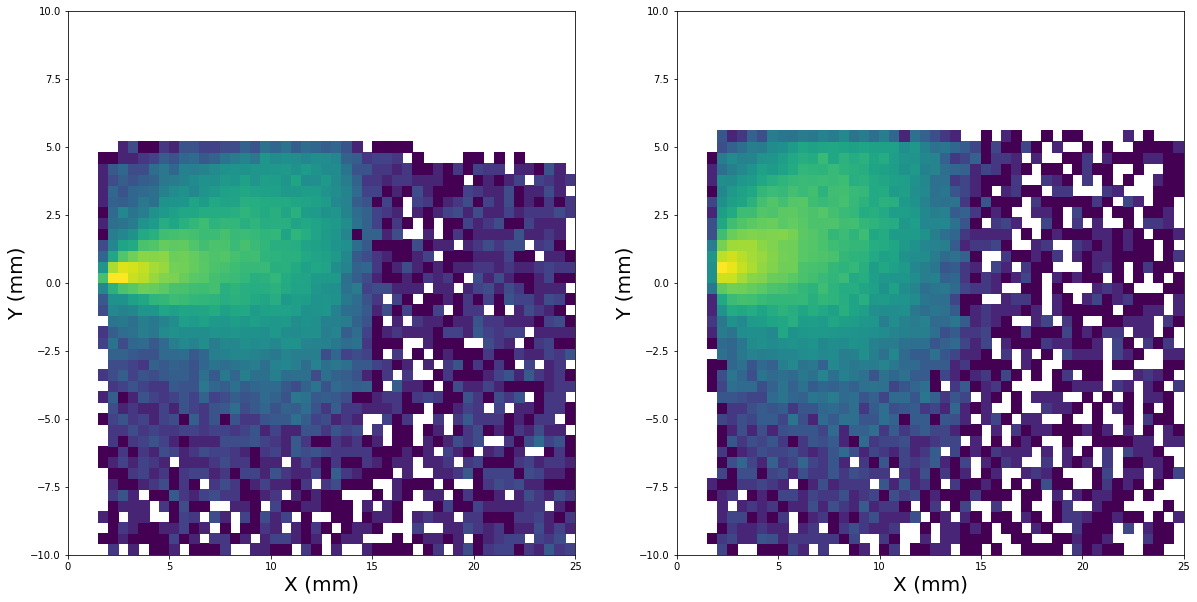

In [13]:
msk_excl = ( df_signal["InvMass"] >= 110. ) & ( df_signal["Acopl"] <= 0.009 ) & ( df_signal["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )
    
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].hist2d( df_data[ "TrackX1" ][ msk_protons_1 ], df_data[ "TrackY1" ][ msk_protons_1 ], bins=(50,50), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[0].set_xlabel( "X (mm)", fontsize=20 )
axes[0].set_ylabel( "Y (mm)", fontsize=20 )
axes[1].hist2d( df_data[ "TrackX1" ][ msk_protons_2 ], df_data[ "TrackY1" ][ msk_protons_2 ], bins=(50,50), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[1].set_xlabel( "X (mm)", fontsize=20 )
axes[1].set_ylabel( "Y (mm)", fontsize=20 )

Proton selection: SingleRP
Number of protons: 103, 82


Text(0, 0.5, '$\\xi_{\\mu\\mu}$')

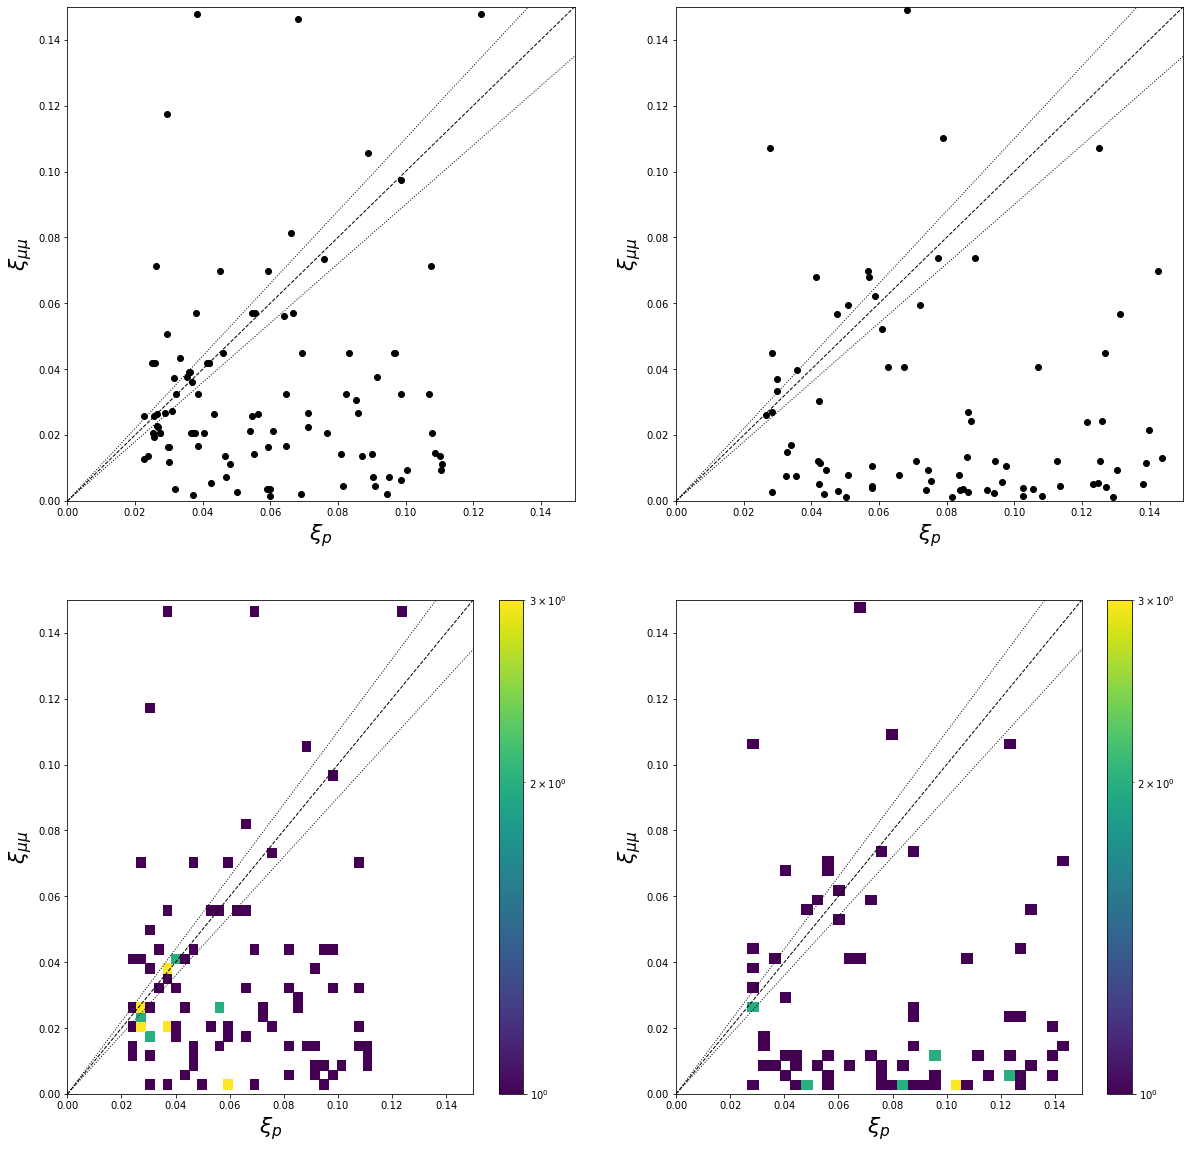

In [14]:
msk_excl = ( df_data["InvMass"] >= 110. ) & ( df_data["Acopl"] <= 0.009 ) & ( df_data["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )

print ( "Proton selection: {}".format( proton_selection ) )
print ( "Number of protons: {}, {}".format( len( df_data[ "Xi" ][ msk_protons_1 ] ), len( df_data[ "Xi" ][ msk_protons_2 ] ) ) )

fig, axes = plt.subplots( 2, 2, figsize=(20,20) )
axes[0,0].plot( df_data[ "Xi" ][ msk_protons_1 ], df_data[ "XiMuMuPlus" ][ msk_protons_1 ], 'ko' )
axes[0,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,0].set_xlim(0.,0.15)
axes[0,0].set_ylim(0.,0.15)
axes[0,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
axes[0,1].plot( df_data[ "Xi" ][ msk_protons_2 ], df_data[ "XiMuMuMinus" ][ msk_protons_2 ], 'ko' )
axes[0,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,1].set_xlim(0.,0.15)
axes[0,1].set_ylim(0.,0.15)
axes[0,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,0].hist2d( df_data[ "Xi" ][ msk_protons_1 ], df_data[ "XiMuMuPlus" ][ msk_protons_1 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,0])
axes[1,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,0].set_xlim(0.,0.15)
axes[1,0].set_ylim(0.,0.15)
axes[1,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,1].hist2d( df_data[ "Xi" ][ msk_protons_2 ], df_data[ "XiMuMuMinus" ][ msk_protons_2 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,1])
axes[1,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,1].set_xlim(0.,0.15)
axes[1,1].set_ylim(0.,0.15)
axes[1,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )